In [1]:
import os
import cv2
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout,Flatten
from keras.models import Model, load_model
import tensorflow as tf
from tensorflow.keras import regularizers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')
classes=df.columns[1:]
classes


Index(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')

In [3]:
parent_folder="baru"

In [4]:
if os.path.isdir(parent_folder):
    shutil.rmtree(parent_folder)
os.mkdir(parent_folder)
for i in classes:
    folder=os.path.join(parent_folder,i)
    os.mkdir(folder)

In [5]:
def preprocessing(image):
    gambar=cv2.imread(f"/kaggle/input/ham1000-segmentation-and-classification/images/{image}.jpg",cv2.IMREAD_COLOR)
    resize=cv2.resize(gambar,[224,224])
    grayScale = cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian blur
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #masking
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(resize,mask,6,cv2.INPAINT_TELEA)   
    return dst
for cls in classes:
    images = df[df[cls]==1]['image'].to_list()
    for image in images:
        gambar=preprocessing(image)
        cv2.imwrite(f"baru/{cls}/{image}.jpg",gambar)


In [6]:

def splitting(location):
    files=[]
    labels=[]
    classes=os.listdir(location)
    for cls in classes:
        path=os.path.join(location,cls)
        list_file=os.listdir(path)
        for file in list_file:
            file_path=os.path.join(path,file)
            files.append(file_path)
            labels.append(cls)
    filepath=pd.Series(files,name="path")
    labelpath=pd.Series(labels,name="label")
    dataset=pd.concat([filepath,labelpath],axis=1)
    strat=dataset['label']
    train_dataset,test_valid_dataset=train_test_split(dataset,train_size=0.8,shuffle=True,random_state=42,stratify=strat)
    strat_test_valid=test_valid_dataset["label"]
    test_dataset,validation_dataset=train_test_split(test_valid_dataset,train_size=0.5,shuffle=True,random_state=42,stratify=strat_test_valid) 
    print('train_df length: ', len(train_dataset), '  test_df length: ',len(test_dataset), '  valid_df length: ', len(validation_dataset))
    print(train_dataset['label'].value_counts())
    return train_dataset,test_dataset,validation_dataset   

In [7]:
train_dataset,test_dataset,validation_dataset=splitting(parent_folder)

train_df length:  8012   test_df length:  1001   valid_df length:  1002
label
NV       5364
MEL       890
BKL       879
BCC       411
AKIEC     262
VASC      114
DF         92
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [8]:
train_data_count=train_dataset['path'].count()
avg_data_train=int(np.ceil(train_data_count/7))
print(avg_data_train)

1145


In [9]:
val_data_count=validation_dataset['path'].count()
avg_data_val=int(np.ceil(val_data_count/7))
print(avg_data_val)

144


In [10]:
augmented_train_location="augmented_train"
augmented_val_location="augmented_val"
def balancing(dataset,size,train):
    if train==True:
        if os.path.isdir(augmented_train_location):
            shutil.rmtree(augmented_train_location)
        os.mkdir(augmented_train_location)
        for i in dataset['label'].unique():
            os.mkdir(os.path.join(augmented_train_location,i))
    elif train==False:
        if os.path.isdir(augmented_val_location):
            shutil.rmtree(augmented_val_location)
        os.mkdir(augmented_val_location)
        for i in dataset['label'].unique():
            os.mkdir(os.path.join(augmented_val_location,i))
    data=dataset.copy()
    reduce=[]
    grouping=data.groupby("label")
    for i in data['label'].unique():
        group_per_type=grouping.get_group(i)
        if train==True:
            count=len(group_per_type)
            if count > size:
                sampling=group_per_type.sample(size, replace=False, weights=None, random_state=42, axis=0).reset_index(drop=True)
                reduce.append(sampling)
            elif count <=size:
                reduce.append(group_per_type)
        elif train ==False:
            reduce.append(group_per_type)
    reduced_dataset=pd.concat(reduce,axis=0).reset_index(drop=True)
    generator=ImageDataGenerator(horizontal_flip=True,rotation_range=90,width_shift_range=2,height_shift_range=2)
    grouping=reduced_dataset.groupby("label")
    for type in reduced_dataset['label'].unique():
        group_per_type=grouping.get_group(type)
        count=len(group_per_type)
        if count < size:
            augmented_count=0
            delta=size-count
            if train==True:
                location=os.path.join(augmented_train_location,type)
            elif train==False:
                location=os.path.join(augmented_val_location,type)
            augmentation_generator=generator.flow_from_dataframe(group_per_type,x_col='path',y_col=None,target_size=(224,224), class_mode=None,
                                                                  batch_size=1, shuffle=False,save_to_dir=location, save_prefix='augmented_',
                                                                  color_mode='rgb',save_format='jpg')
            while augmented_count<delta:
                images=next(augmentation_generator)
                augmented_count+=len(images)
    files=[]
    labels=[]
    if train==True:
        classes=os.listdir(augmented_train_location)
    elif train==False:
        classes=os.listdir(augmented_val_location)
    for cls in classes:
        if train==True:
            path=os.path.join(augmented_train_location,cls)
        elif train==False:
            path=os.path.join(augmented_val_location,cls)
        list_file=os.listdir(path)
        for file in list_file:
            file_path=os.path.join(path,file)
            files.append(file_path)
            labels.append(cls)
    filepath=pd.Series(files,name="path")
    labelpath=pd.Series(labels,name="label")
    augmented_dataset=pd.concat([filepath,labelpath],axis=1)
    combined_dataset=pd.concat([reduced_dataset,augmented_dataset],axis=0).reset_index(drop=True)
    return combined_dataset


In [11]:
# balanced_train_dataset=balancing(train_dataset,avg_data_train,True)
# balanced_train_dataset=balancing(train_dataset,800)
# print(balanced_train_dataset['label'].value_counts())
balanced_train_dataset=train_dataset
# balanced_val=balancing(validation_dataset,avg_data_val,False)

In [12]:
batch_size=32
img_size=(224,224)
img_shape=(224,224,3)
length=len(test_dataset)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=64],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def process(image):
    return image
generator_for_training=ImageDataGenerator(preprocessing_function=process,horizontal_flip=True)
generator=ImageDataGenerator(preprocessing_function=process)

train_generator=generator_for_training.flow_from_dataframe(balanced_train_dataset,x_col='path',y_col='label',
                                                           target_size=img_size,class_mode='categorical',color_mode='rgb',
                                                           shuffle=True,batch_size=batch_size)
validation_generator=generator.flow_from_dataframe(validation_dataset,x_col='path',y_col='label',
                                                   target_size=img_size,class_mode='categorical',color_mode='rgb',
                                                   shuffle=True,batch_size=batch_size)
test_generator=generator.flow_from_dataframe(test_dataset,x_col='path',y_col='label', 
                                             target_size=img_size,class_mode='categorical',color_mode='rgb',
                                             shuffle=False,batch_size=test_batch_size)
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

test batch size:  13   test steps:  77
Found 8012 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.


In [13]:
learning_rate=1e-4
epoch=30
factor=learning_rate/epoch
def efficientnet_b2():
    input=Input(shape=img_shape)
    base=tf.keras.applications.EfficientNetB2(weights='imagenet',include_top=False,input_shape=img_shape,input_tensor=input,classes=7)
#     base.trainable=False
#     x=Flatten()(base.output)
    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(7, activation='softmax',kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(x)
#     output = Dense(7, activation='softmax')(x)
    model = Model(input, output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])
    return model
efficientnet_b2_model=efficientnet_b2()

31790344/31790344 [==============================] - 0s 0us/step


In [14]:
# efficientnet_b2_model.summary()

In [15]:
#stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True,verbose=1,patience=5) 
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor,patience=5, min_lr=learning_rate,verbose=1) 
checkpoint=tf.keras.callbacks.ModelCheckpoint("efficientnet_b2_model.h5",monitor="val_loss",mode="min",save_best_only = True,verbose=1)
callback_list = [ reduce_lr, checkpoint]

In [16]:
classifier_history = efficientnet_b2_model.fit(train_generator, batch_size=batch_size,
                validation_data=validation_generator,
                steps_per_epoch=train_steps,
                validation_steps=None,
                epochs=epoch,
                callbacks=callback_list
)

Epoch 1/30


2023-12-16 04:31:42.544844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


251/251 [==============================] - ETA: 0s - loss: 3.0576 - accuracy: 0.5406
Epoch 1: val_loss improved from inf to 2.22954, saving model to efficientnet_b2_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 148s 334ms/step - loss: 3.0576 - accuracy: 0.5406 - val_loss: 2.2295 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 2/30
251/251 [==============================] - ETA: 0s - loss: 2.3265 - accuracy: 0.6787
Epoch 2: val_loss improved from 2.22954 to 1.96779, saving model to efficientnet_b2_model.h5
251/251 [==============================] - 81s 321ms/step - loss: 2.3265 - accuracy: 0.6787 - val_loss: 1.9678 - val_accuracy: 0.7735 - lr: 1.0000e-04
Epoch 3/30
251/251 [==============================] - ETA: 0s - loss: 2.0491 - accuracy: 0.7247
Epoch 3: val_loss improved from 1.96779 to 1.80678, saving model to efficientnet_b2_model.h5
251/251 [==============================] - 81s 320ms/step - loss: 2.0491 - accuracy: 0.7247 - val_loss: 1.8068 - val_accuracy: 0.7954 - lr: 1.0000e-04
Epoch 4/30
251/251 [==============================] - ETA: 0s - loss: 1.8361 - accuracy: 0.7621
Epoch 4: val_loss improved from 1.80678 to 1.65428, saving model to effi

In [17]:
def plot_history(history, title, plot_type, xlabel, ylabel):
    plt.figure(figsize=(12,8))
    if plot_type == 'accuracy':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
    else:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
    plt.title('Model Accuracy')
    plt.ylabel('{}'.format(ylabel))
    plt.xlabel('{}'.format(xlabel))
    plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
    plt.title('{}'.format(title))
    plt.savefig('{}.png'.format(title))
    plt.show()

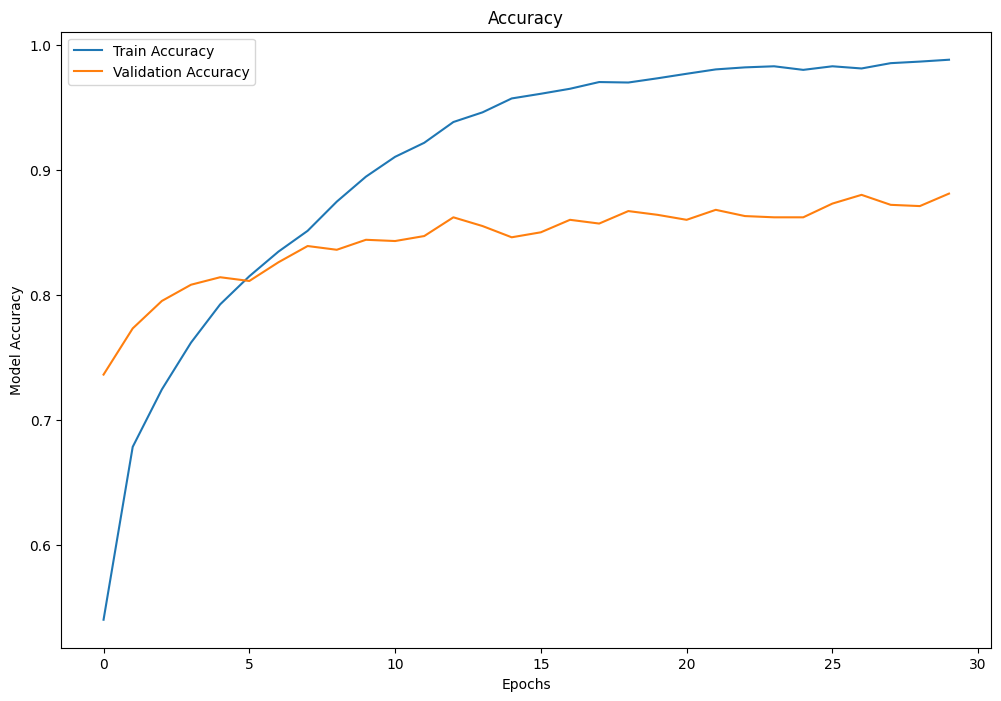

In [18]:
plot_history(classifier_history, 'Accuracy', 'accuracy', 'Epochs', 'Model Accuracy')

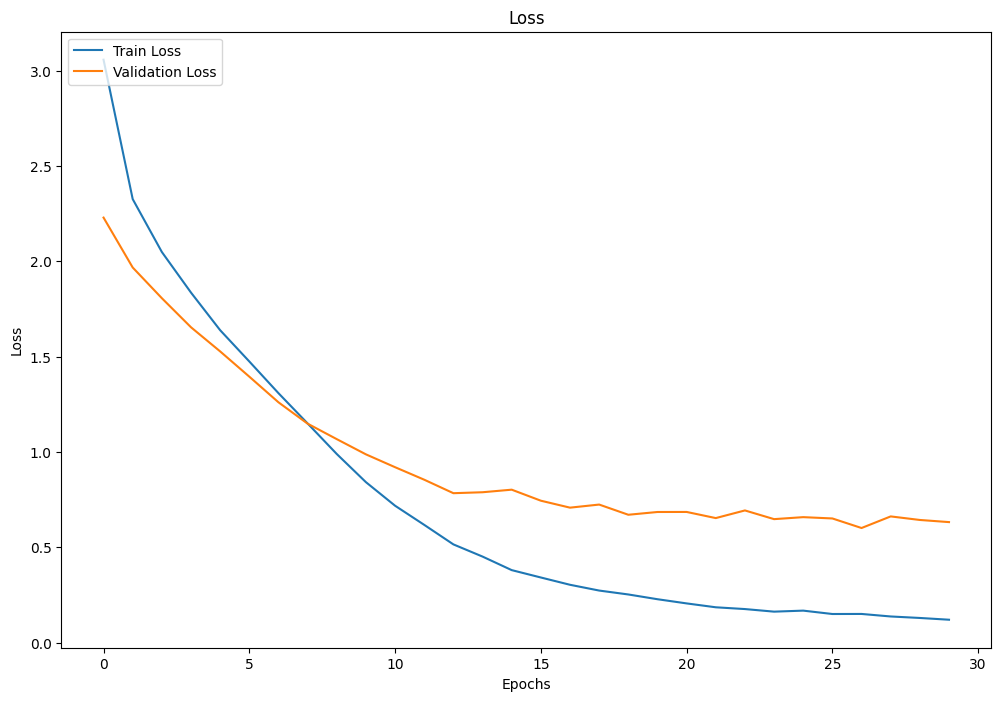

In [19]:
plot_history(classifier_history, 'Loss', 'loss', 'Epochs', 'Loss')

In [20]:
acc=efficientnet_b2_model.evaluate( test_generator, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
print(f'accuracy on the test set is {acc:5.2f} %')

77/77 [==============================] - 3s 30ms/step - loss: 0.7389 - accuracy: 0.8412
accuracy on the test set is 84.12 %


In [21]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
sns.set_style('darkgrid')

In [22]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

77/77 [==============================] - 4s 26ms/step


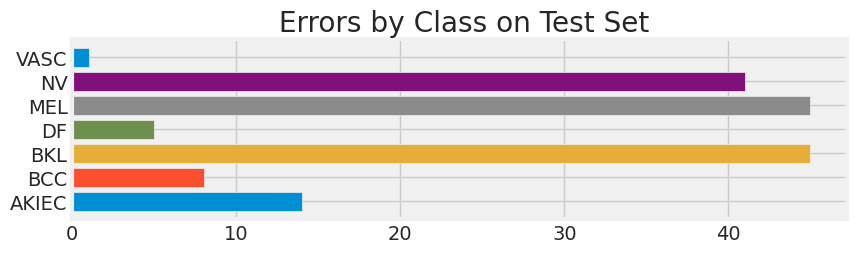

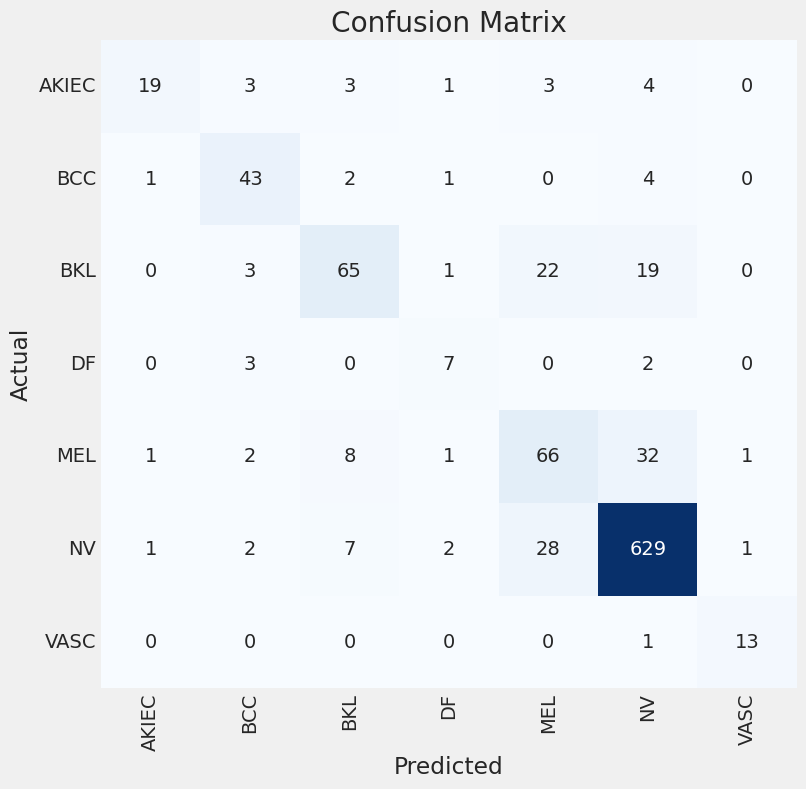

Classification Report:
----------------------
               precision    recall  f1-score   support

       AKIEC       0.86      0.58      0.69        33
         BCC       0.77      0.84      0.80        51
         BKL       0.76      0.59      0.67       110
          DF       0.54      0.58      0.56        12
         MEL       0.55      0.59      0.57       111
          NV       0.91      0.94      0.92       670
        VASC       0.87      0.93      0.90        14

    accuracy                           0.84      1001
   macro avg       0.75      0.72      0.73      1001
weighted avg       0.84      0.84      0.84      1001



In [23]:
print_code=0
subject='skin disease'
preds=efficientnet_b2_model.predict(test_generator, steps=test_steps, verbose=1) 
print_info( test_generator, preds, print_code, r'./', subject )  

In [24]:
efficientnet_b2_model.save("efficientnet_b2_model_coba.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
